In [1]:
!pip install kaggle

In [2]:
! pip install -q git+https://github.com/keras-team/keras-cv

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 11.6 MB/s eta 0:00:00


In [4]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [6]:
import os
# You can use `tensorflow`, `pytorch`, `jax` here
# KerasCore makes the notebook backend agnostic :)
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_cv
import keras_core as keras
from keras_core import layers

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend


Config

In [15]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 16
    EPOCHS = 100
    TARGET_COLS = [
        "extravasation"
    ]
    AUTOTUNE = tf.data.AUTOTUNE

config = Config()

In [8]:
keras.utils.set_random_seed(seed=config.SEED)

Dataset

In [9]:
BASE_PATH = "/content/drive/MyDrive/rsna_data"

In [10]:
# CSV 파일을 읽어와서 데이터프레임 생성
train_df = pd.read_csv(f"{BASE_PATH}/train.csv")
series_meta_df = pd.read_csv(f"{BASE_PATH}/train_series_meta.csv")

# train.csv와 train_series_meta.csv를 patient_id를 기준으로 병합
dataframe = pd.merge(train_df, series_meta_df, on="patient_id")

# 이미지 경로 생성
dataframe["image_path"] = f"/content/drive/MyDrive/png_jjw"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + "img_256x256_d3_normalization"\

# 처음 2개 행 출력
dataframe.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,aortic_hu,incomplete_organ,image_path
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,146.00,0,/content/drive/MyDrive/png_jjw/10004/21057/img...
1,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,51033,454.75,0,/content/drive/MyDrive/png_jjw/10004/51033/img...
2,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0,18667,187.00,0,/content/drive/MyDrive/png_jjw/10005/18667/img...
3,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0,47578,329.00,0,/content/drive/MyDrive/png_jjw/10007/47578/img...
4,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0,29700,327.00,0,/content/drive/MyDrive/png_jjw/10026/29700/img...


In [11]:
dataframe = dataframe[dataframe['any_injury'] == 1]
dataframe = dataframe.reset_index(drop=True)
print(dataframe.shape)

(1288, 19)


In [12]:
def bowel_assign_value(row):
    if row['bowel_healthy'] == 1:
        return 0
    else:
        return 1

def extra_assign_value(row):
    if row['extravasation_healthy'] == 1:
        return 0
    else:
        return 1

def kid_assign_value(row):
    if row['kidney_healthy'] == 1:
        return 0
    elif row['kidney_low'] == 1:
        return 1
    elif row['kidney_high'] == 1:
        return 2
    else:
        return None
def liver_assign_value(row):
    if row['liver_healthy'] == 1:
        return 0
    elif row['liver_low'] == 1:
        return 1
    elif row['liver_high'] == 1:
        return 2
    else:
        return None

def spleen_assign_value(row):
    if row['spleen_healthy'] == 1:
        return 0
    elif row['spleen_low'] == 1:
        return 1
    elif row['spleen_high'] == 1:
        return 2
    else:
        return None

dataframe['bowel'] = dataframe.apply(bowel_assign_value, axis=1)
dataframe['extravasation'] = dataframe.apply(extra_assign_value, axis=1)
dataframe['kidney'] = dataframe.apply(kid_assign_value, axis=1)
dataframe['liver'] = dataframe.apply(liver_assign_value, axis=1)
dataframe['spleen'] = dataframe.apply(spleen_assign_value, axis=1)

In [13]:
dataframe = dataframe[["patient_id", "bowel", "extravasation", "kidney", "liver", "spleen", "image_path"]]
dataframe

,patient_id,bowel,extravasation,kidney,liver,spleen,image_path
0,10004,0,1,1,0,2,/content/drive/MyDrive/png_jjw/10004/21057/img...
1,10004,0,1,1,0,2,/content/drive/MyDrive/png_jjw/10004/51033/img...
2,10051,0,0,0,0,1,/content/drive/MyDrive/png_jjw/10051/17486/img...
3,10051,0,0,0,0,1,/content/drive/MyDrive/png_jjw/10051/50172/img...
4,10065,1,0,0,0,0,/content/drive/MyDrive/png_jjw/10065/37324/img...
...,...,...,...,...,...,...,...
1283,9703,0,0,0,2,1,/content/drive/MyDrive/png_jjw/9703/39470/img_...
1284,9813,0,0,0,1,2,/content/drive/MyDrive/png_jjw/9813/24149/img_...
1285,9980,0,0,0,0,2,/content/drive/MyDrive/png_jjw/9980/40214/img_...
1286,9980,0,0,0,0,2,/content/drive/MyDrive/png_jjw/9980/40466/img_...


In [16]:
# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

train_data = pd.DataFrame()
val_data = pd.DataFrame()

for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

<ipython-input-16-f06124e34cab>:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in dataframe.groupby(config.TARGET_COLS):


In [17]:
train_data

,patient_id,bowel,extravasation,kidney,liver,spleen,image_path
0,60515,0,0,0,0,1,/content/drive/MyDrive/png_jjw/60515/23631/img...
1,21050,0,0,0,2,0,/content/drive/MyDrive/png_jjw/21050/6536/img_...
2,26792,0,0,0,1,0,/content/drive/MyDrive/png_jjw/26792/62808/img...
3,12698,0,0,0,0,1,/content/drive/MyDrive/png_jjw/12698/5060/img_...
4,6097,0,0,0,0,1,/content/drive/MyDrive/png_jjw/6097/22723/img_...
...,...,...,...,...,...,...,...
1025,44861,0,1,0,0,0,/content/drive/MyDrive/png_jjw/44861/6483/img_...
1026,23029,0,1,0,0,0,/content/drive/MyDrive/png_jjw/23029/54527/img...
1027,29448,0,1,0,0,0,/content/drive/MyDrive/png_jjw/29448/14488/img...
1028,5914,0,1,0,0,2,/content/drive/MyDrive/png_jjw/5914/18543/img_...


In [18]:
def decode_image_and_label(image_path, label):
    file_bytes1 = tf.io.read_file(image_path+'/image_001.png')
    image1 = tf.io.decode_png(file_bytes1, channels=1, dtype=tf.uint8)
    file_bytes2 = tf.io.read_file(image_path+'/image_002.png')
    image2 = tf.io.decode_png(file_bytes2, channels=1, dtype=tf.uint8)
    file_bytes3 = tf.io.read_file(image_path+'/image_003.png')
    image3 = tf.io.decode_png(file_bytes3, channels=1, dtype=tf.uint8)
    image = tf.concat([image1, image2, image3], axis=2)

    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0

    label = tf.cast(label, tf.float32)

    return (image, label)

In [19]:
import tensorflow as tf
import keras_cv.layers

# 레이어 외부에서 RandomFlip 레이어를 생성
random_flip_layer = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
random_rotation_layer = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)

class CustomAugmenter(tf.keras.layers.Layer):
    def __init__(self, cutout_params, **kwargs):
        super(CustomAugmenter, self).__init__(**kwargs)
        self.cutout_layer = keras_cv.layers.Augmenter([keras_cv.layers.RandomCutout(**cutout_params)])

    def call(self, inputs, training=None):
        if training:
            inputs = random_flip_layer(inputs)
            inputs = random_rotation_layer(inputs)
            inputs = self.cutout_layer(inputs)
        return inputs

def apply_augmentation(images, labels):
    # 이미지 증강 파이프라인을 정의합니다.
    augmenter = CustomAugmenter(cutout_params={"height_factor": 0.2, "width_factor": 0.2})

    # 이미지 증강을 적용합니다.
    augmented_images = augmenter(images, training=True)

    return (augmented_images, labels)

In [20]:
def build_dataset(image_paths, labels):
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .map(apply_augmentation, num_parallel_calls=config.AUTOTUNE)  # 이미지 증강 적용
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [21]:
paths = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values
print(len(paths))
print(labels.shape)

1030
(1030, 1)


In [22]:
paths = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

ds = build_dataset(image_paths=paths, labels=labels)
images, labels = next(iter(ds))
images.shape, [label.shape for label in labels]

(TensorShape([16, 256, 256, 3]),
 [TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1])])

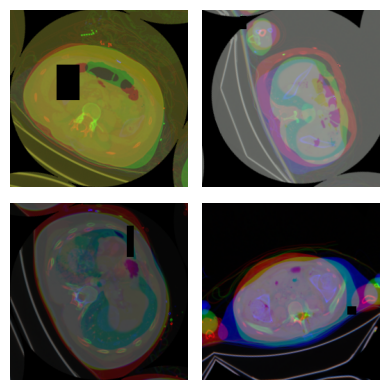

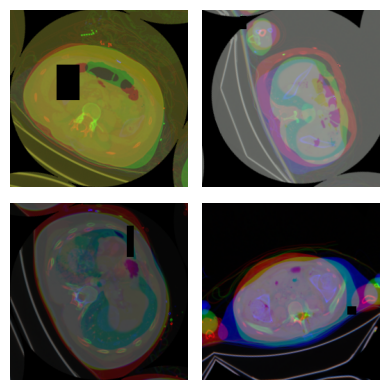

In [23]:
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=2,
    cols=2,
)

Model

Efficientnet

In [24]:
def build_binary_classification_model(warmup_steps, decay_steps, head_name):
    # Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)

    # Define Backbone
    backbone = keras_cv.models.EfficientNetV2Backbone.from_preset("efficientnetv2_b3")
    backbone.include_rescaling = False
    x = backbone(inputs)

    # GAP to get the activation maps
    gap = keras.layers.GlobalAveragePooling2D()
    x = gap(x)

    # Define 'necks' for the binary classification head
    x_head = keras.layers.Dense(32, activation='silu')(x)

    # Define binary classification head
    output = keras.layers.Dense(1, name=head_name, activation='sigmoid')(x_head)

    # Create model
    print(f"[INFO] Building the {head_name} model...")
    model = keras.Model(inputs=inputs, outputs=output)

    # Cosine Decay
    cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.0,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)
    loss = keras.losses.BinaryCrossentropy()
    metrics = ["accuracy"]

    print(f"[INFO] Compiling the {head_name} model...")
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    return model

def build_tertiary_classification_model(warmup_steps, decay_steps, head_name):
    # Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)

    # Define Backbone
    backbone = keras_cv.models.EfficientNetV2Backbone.from_preset("efficientnetv2_b3")
    backbone.include_rescaling = False
    x = backbone(inputs)

    # GAP to get the activation maps
    gap = keras.layers.GlobalAveragePooling2D()
    x = gap(x)

    # Define 'necks' for the tertiary classification head
    x_head = keras.layers.Dense(32, activation='silu')(x)

    # Define tertiary classification head
    output = keras.layers.Dense(3, name=head_name, activation='softmax')(x_head)

    # Create model
    print(f"[INFO] Building the {head_name} model...")
    model = keras.Model(inputs=inputs, outputs=output)

    # Cosine Decay
    cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.0,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)
    loss = keras.losses.CategoricalCrossentropy()
    metrics = ["accuracy"]

    print(f"[INFO] Compiling the {head_name} model...")
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    return model

Train

In [27]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values
valid_paths = val_data.image_path.values

train_labels = train_data[config.TARGET_COLS].values.astype(np.int32)
valid_labels = val_data[config.TARGET_COLS].values.astype(np.int32)

# # One-hot encode the labels
# train_labels = keras.utils.to_categorical(train_labels, num_classes=3)
# valid_labels = keras.utils.to_categorical(valid_labels, num_classes=3)

# train and valid dataset
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...
total_train_steps=104000
warmup_steps=10400
decay_steps=93600


[INFO] Building the extra model...
[INFO] Compiling the extra model...
Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 664s 7s/step - accuracy: 0.9390 - loss: 0.3917 - val_accuracy: 0.7674 - val_loss: 0.6200
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.8116 - loss: 0.5408 - val_accuracy: 0.6977 - val_loss: 8.7485
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.6744 - loss: 0.6851 - val_accuracy: 0.5891 - val_loss: 0.7137
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.6920 - loss: 0.5893 - val_accuracy: 0.7636 - val_loss: 0.6156
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - accuracy: 0.8129 - loss: 0.5713 - val_accuracy: 0.4651 - val_loss: 0.6679
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.7943 - loss: 0.5378 - val_accuracy: 0.6977 - val_loss: 1.8910
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.9118 - loss: 0.5848 - val_accuracy: 0.7016 - val_loss: 5.8153
Epoch 8/100
65/65 ━━━

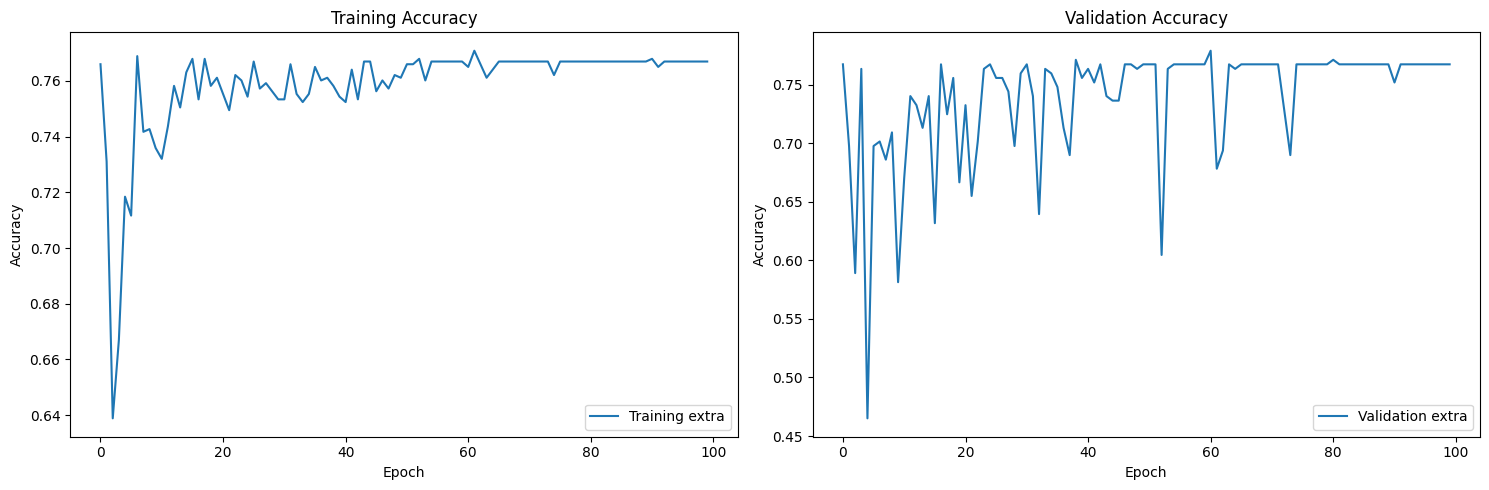

In [28]:
# Directory where you want to save the models
save_dir = BASE_PATH + "/checkpoint/"

# List of model names
model_names = ["extra"]

# Create a 1x2 grid for the subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Flatten axes to iterate through them
axes = axes.flatten()

for i, name in enumerate(model_names):
    # Build the model
    if name in ["bowel", "extra"]:
        model = build_binary_classification_model(warmup_steps, decay_steps, name)
    else:
        model = build_tertiary_classification_model(warmup_steps, decay_steps, name)


    # Train the model
    history = model.fit(train_ds, epochs=config.EPOCHS, validation_data=val_ds)

    model_filename = f"EfficinetnetB3_{name}2.keras"
    model_path = os.path.join(save_dir, model_filename)
    model.save(model_path)

    # Plot training accuracy
    axes[0].plot(history.history['accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[1].plot(history.history['val_accuracy'], label='Validation ' + name)

    axes[0].set_title("Training Accuracy")
    axes[1].set_title("Validation Accuracy")
    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[1].set_ylabel('Accuracy')
    axes[0].legend()
    axes[1].legend()

    plt.tight_layout()
    plt.show()